### Imports

In [1]:
import os
import sys
sys.path.append('..')
import helper as hp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#import umap
from scipy import interpolate

#from sklearn.decomposition import PCA
#from sklearn.metrics import mean_squared_error as rmse
#from sklearn.preprocessing import StandardScaler, MinMaxScaler

### helper functions

In [2]:
def rmse_(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

def calc_rmse(all_sols, idx_to_plot):
    
    rms_df = pd.DataFrame(columns = ['solution_id', 'rms_biomass', 'rms_glucose'])

    for sol_id in idx_to_plot:

        this_sol = all_sols[all_sols['solution_id']==sol_id]
        store_df_vals = []
        store_df_vals.append(sol_id)

        for conc, scaling in dict_scaling.items():

            #load experimental data
            exp_ = exp_data[conc]
            mean = exp_[exp_.columns[1]]
            time_exp = exp_[exp_.columns[0]]
            
            #interpolate simulated data to experimental time
            if time_exp.values[-1]<this_sol['time'].values[-1]:
                f = interpolate.interp1d(this_sol['time'].values, this_sol[conc].values*scaling)
                simulated_interp = f(time_exp.values)
                #calculate rms error between experimental and interpolated simulated data
                this_rmse = rmse_(mean.values, simulated_interp)
                store_df_vals.append(this_rmse)

            else: store_df_vals.append(None)
        rms_df.loc[sol_id] = store_df_vals
        
    # normalize rmse values
    #for col in list(rms_df.columns)[1:]: 
    #    rms_df[col]  = rms_df[col]/np.max(rms_df[col])
    rms_df['total_rmse'] = rms_df['rms_biomass'] + rms_df['rms_glucose']
    
    return rms_df


def get_final_steady_state(path):


    dict_scalings = {'biomass_strain_1': 0.28e-12/0.05, 'glc_D_e': 1e-6, 'ac_e': 1e-6, 'etoh_e': 1e-6, 'for_e': 1e-6,
                    'cit_e': 1e-6, 'co2_e': 1e-6, 'lac_D_e': 1e-6, 'pi_e': 1e-6, 'succ_e': 1e-6}
    all_sols = pd.read_csv(path)
    
    try: 
        all_final_steady_state = pd.read_csv('output/bioreactor_exp/final_ss.csv')
    except FileNotFoundError:
        all_final_steady_state = []
        n_sols = len(np.unique(all_sols['solution_id']))
        for sol_id in range(n_sols):
            this_id_ss = []
            for conc, scaling in dict_scalings.items():
                final_ss = all_sols[all_sols['solution_id']==sol_id][conc].values[-1]*scaling
                this_id_ss.append(final_ss)
            all_final_steady_state.append(this_id_ss)
            
        final_steady_states = pd.DataFrame(all_final_steady_state, columns = list(dict_scalings.keys()))

        return final_steady_states

### Check rewards and stability

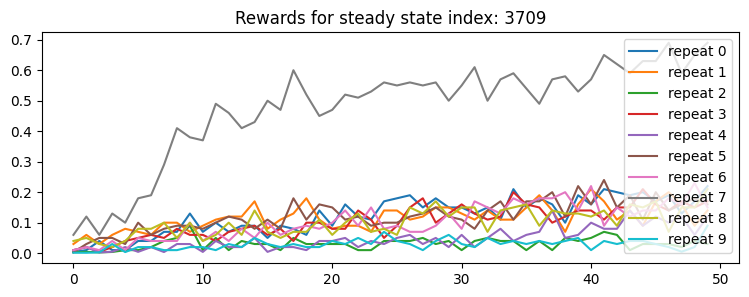

FileNotFoundError: [Errno 2] No such file or directory: 'samples/3709/7/sample_0_max_eigs.csv'

<Figure size 640x480 with 0 Axes>

In [4]:
ss_ixs = [3709]#, 1593, 4327]
reps = 10
generations = 50

for ss_idx in ss_ixs:
    all_rewards = []
    for j in range(reps):
        this_reward = hp.load_pkl(f'../output/rnsc_opt/anaerobic/{ss_idx}/{j}/rewards.pkl')
        all_rewards.append(this_reward)

    plt.figure(figsize = (9,3))
    plt.title(f'Rewards for steady state index: {ss_idx}')
    plt.plot(np.transpose(all_rewards), label = [f'repeat {j}' for j in range(reps)]) 
    plt.legend()
    plt.savefig(f'figures/figure_5/RENAISSANCE_training.svg', dpi=300, transparent=False, bbox_inches='tight')
    plt.show()
    plt.close()

for ss_idx in ss_ixs:
    all_rewards = []
    plt.figure()
    for j in [7]:
        incidence = []
        for gen in range(generations):
            this_max_eigs = pd.read_csv(f'samples/{ss_idx}/{j}/sample_{gen}_max_eigs.csv').iloc[:,1].values
            valid_no = len(np.where(this_max_eigs <0)[0])/len(this_max_eigs)
            incidence.append(valid_no)

    plt.title(f'Rewards for steady state index: {ss_idx}')
    plt.plot(incidence) 
    plt.legend()
    plt.show()
    plt.close()

### Load experimental & simulated data

In [7]:
TOTAL_TIME = 15
N_STEPS = 100

T = np.linspace(0, TOTAL_TIME, N_STEPS)
T_start_ix = np.where(T<0.9603)[-1][-1]

growth = pd.read_csv('exp_data/biomass.csv')
glc = pd.read_csv('exp_data/glucose.csv')
dict_scaling = {'biomass_strain_1': 0.28e-12, 'glc_D_e': 1e-6}#, 'ac_e': 1e-6,
                #'etoh_e': 1e-6, 'for_e': 1e-6} # 1e-6 because we need to present the results in  (mM)
labels = {'biomass_strain_1': 'biomass (g/L)', 'glc_D_e': 'glucose (mM)'}#, 'ac_e': 'acetate (mM)',
          #'etoh_e': 'ethanol (mM)', 'for_e': 'formate (mM)'}
exp_data = {'biomass_strain_1': growth, 'glc_D_e': glc}#, 'ac_e': ac, 'etoh_e': eth, 'for_e': form}

all_exp_mets = [growth, glc]
final_exp_val = []
for this_met in all_exp_mets:
    final_exp_val.append(this_met.iloc[:,1].values[-1])
    
final_exp_ss = {}
for ix, key in enumerate(list(dict_scaling.keys())):
    final_exp_ss[key] = final_exp_val[ix]

### Screening 1 - Plot all responses of a file and check good fits

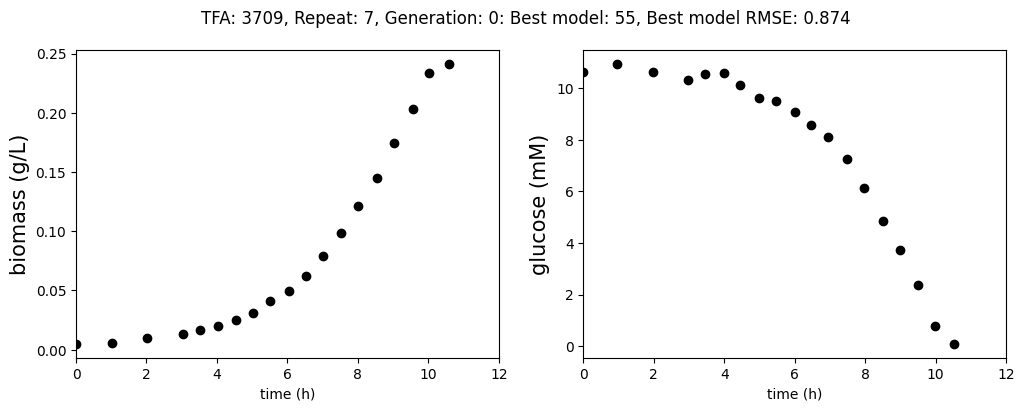

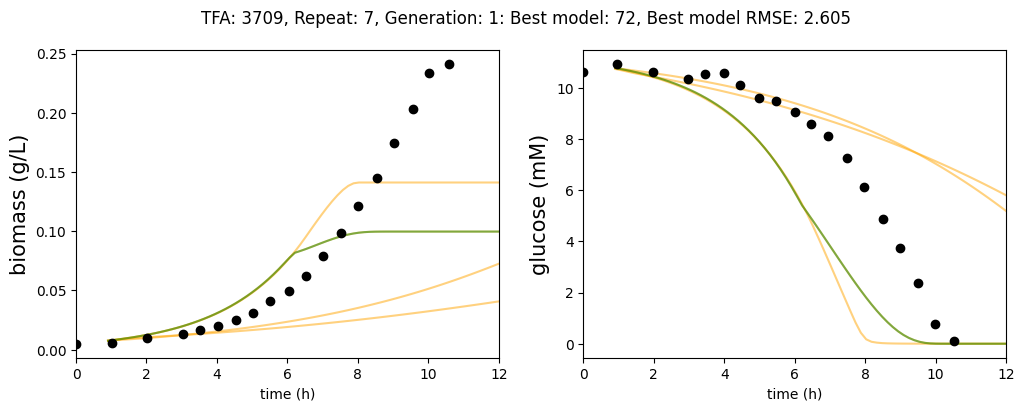

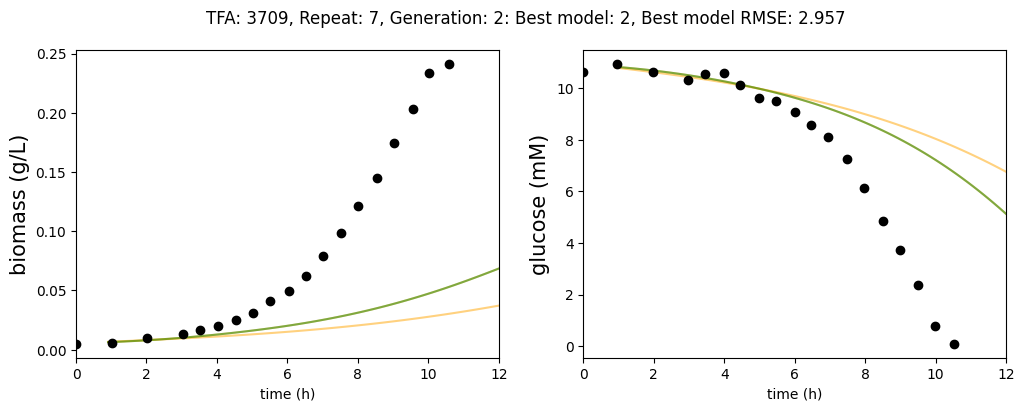

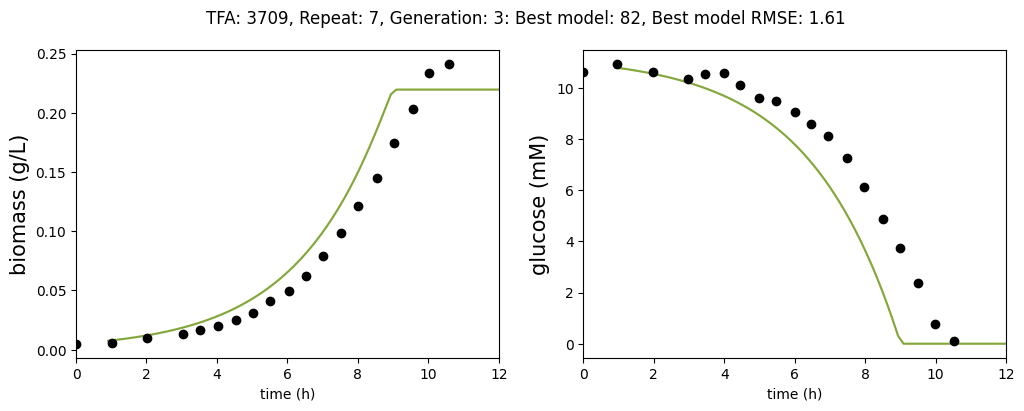

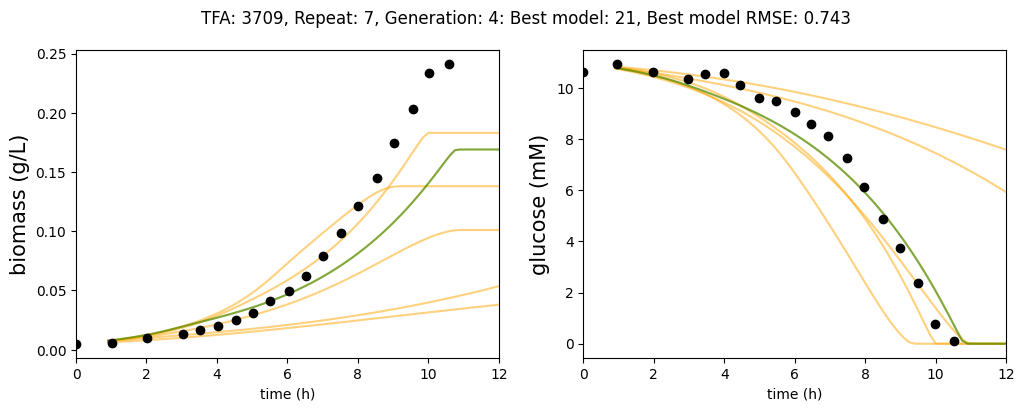

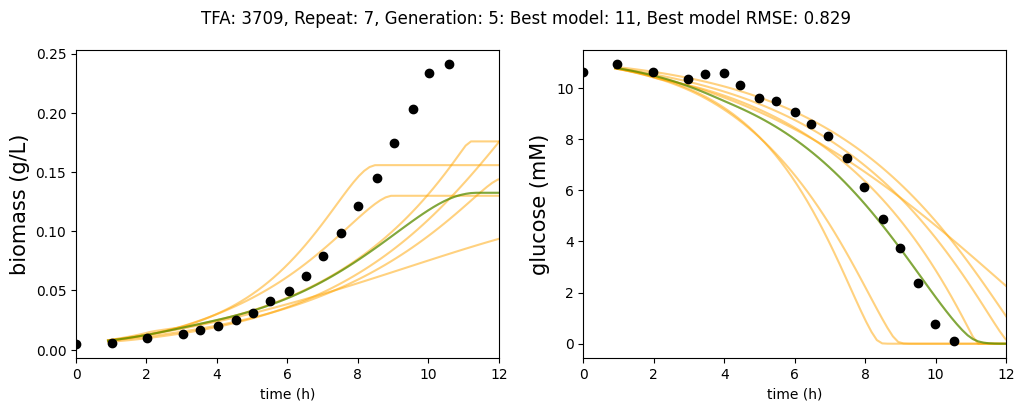

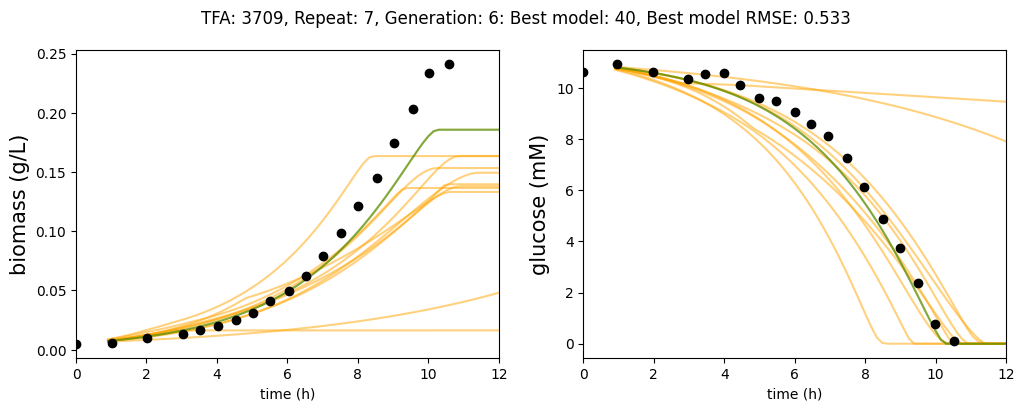

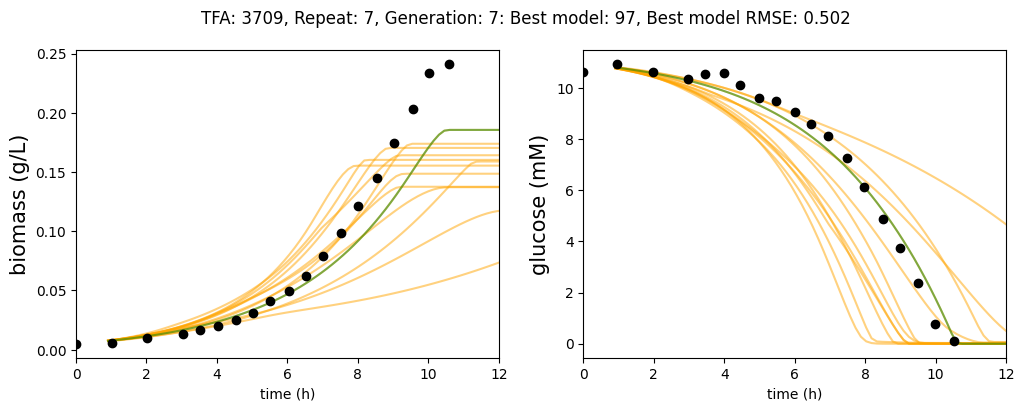

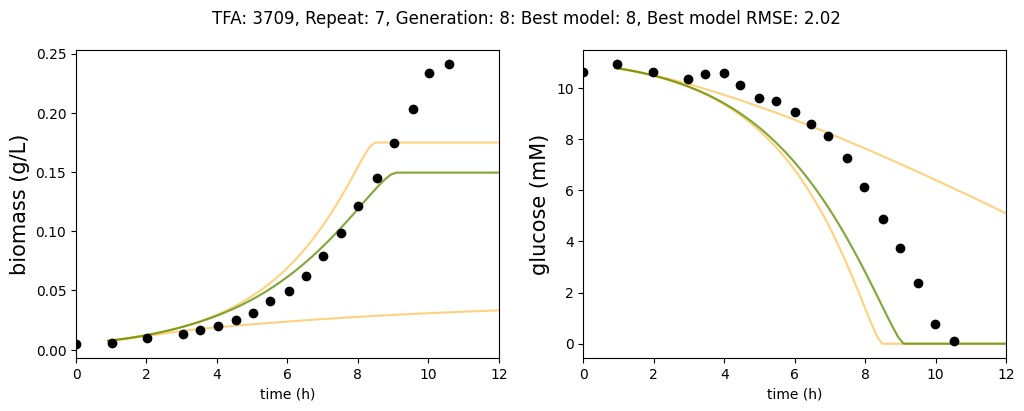

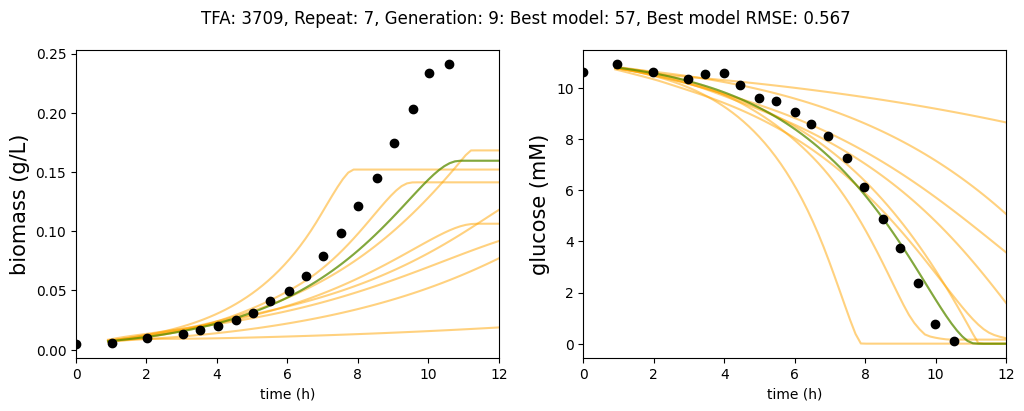

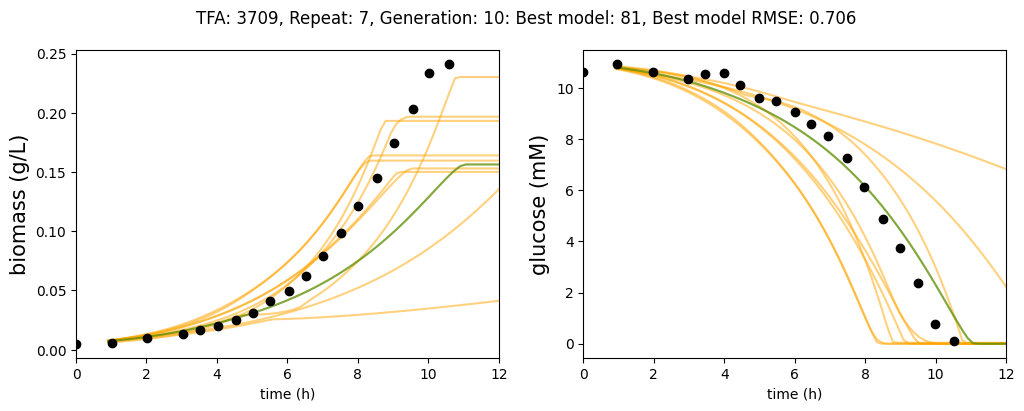

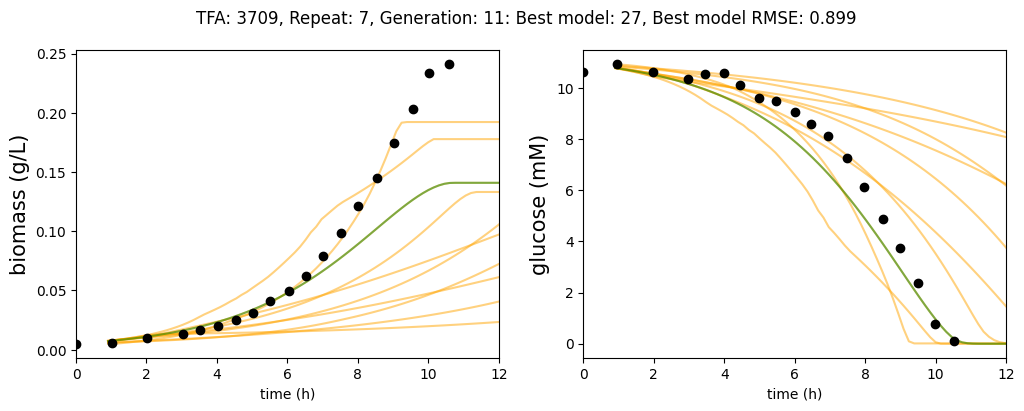

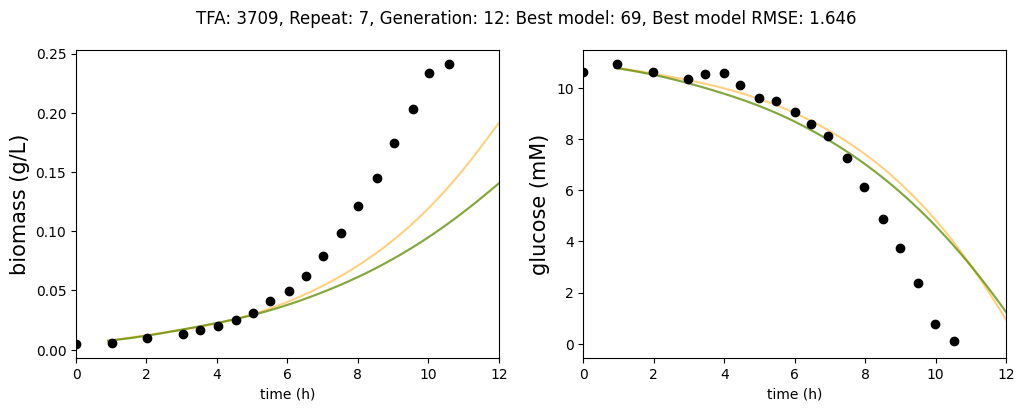

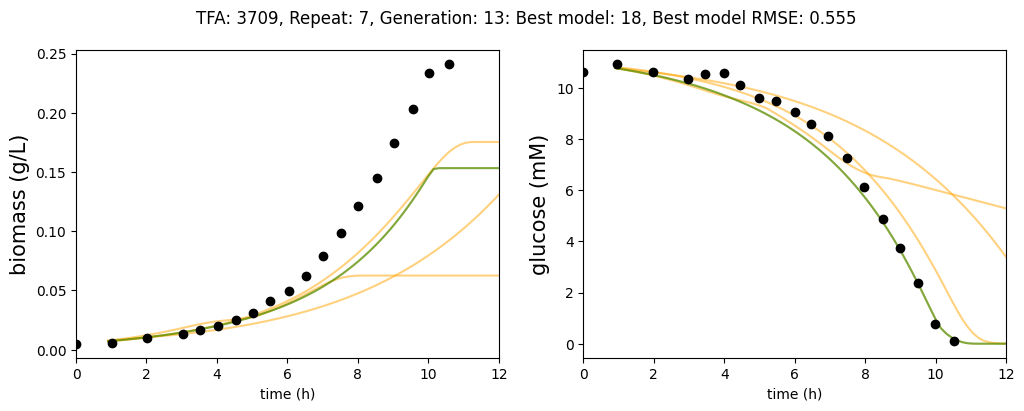

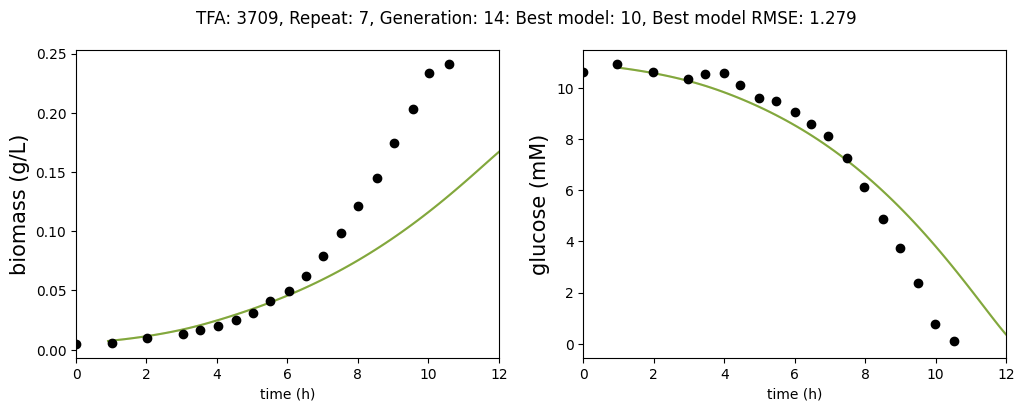

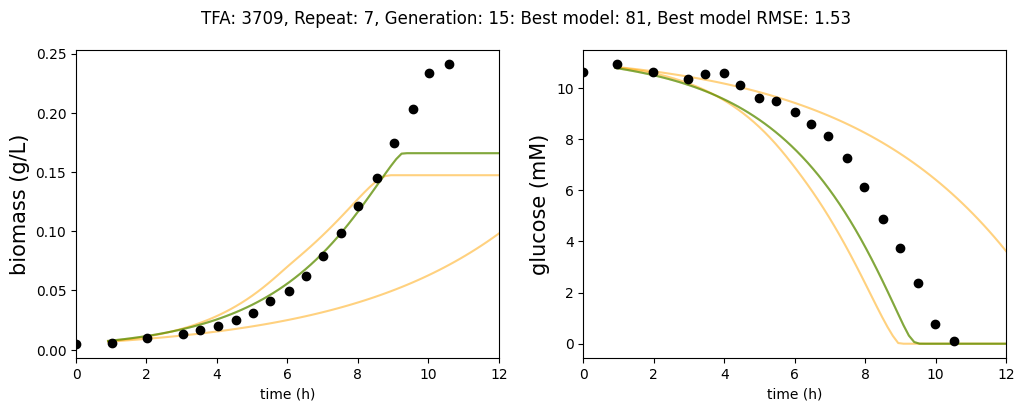

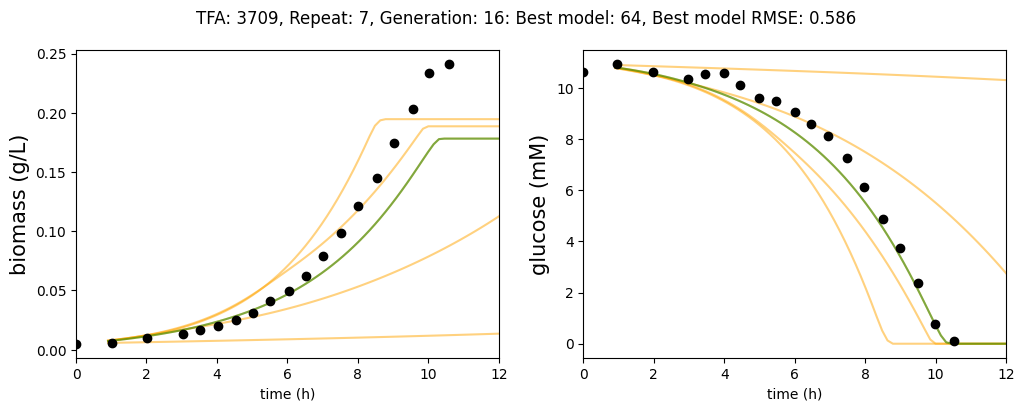

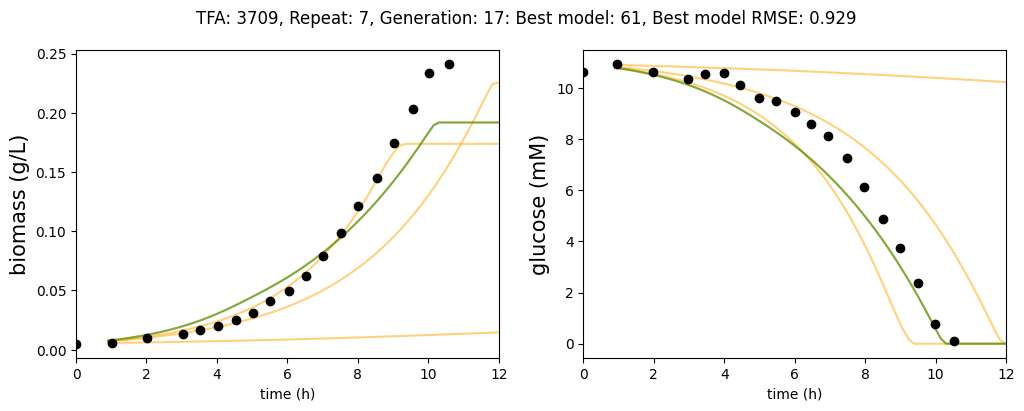

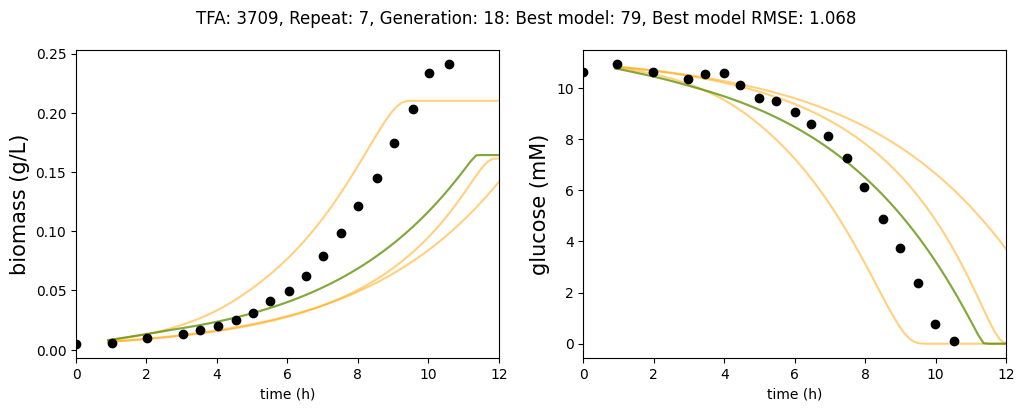

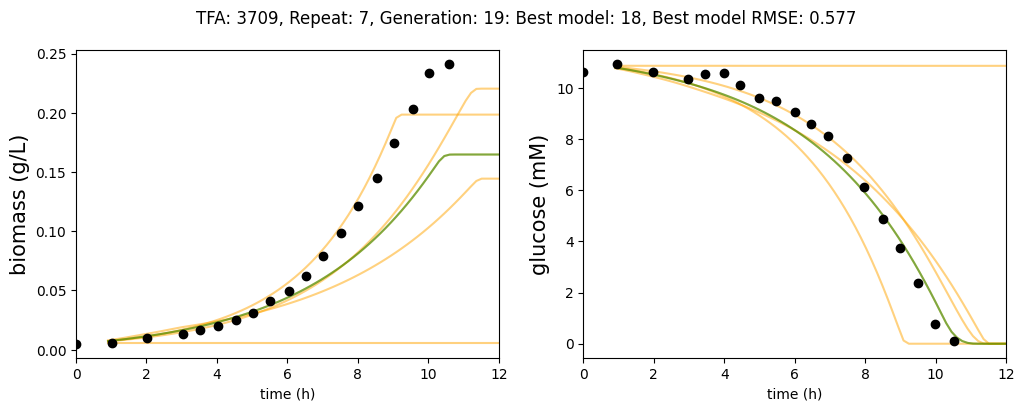

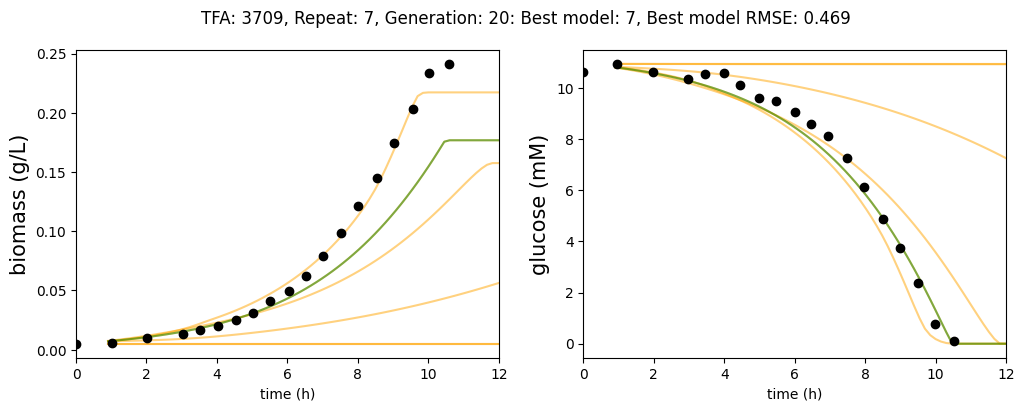

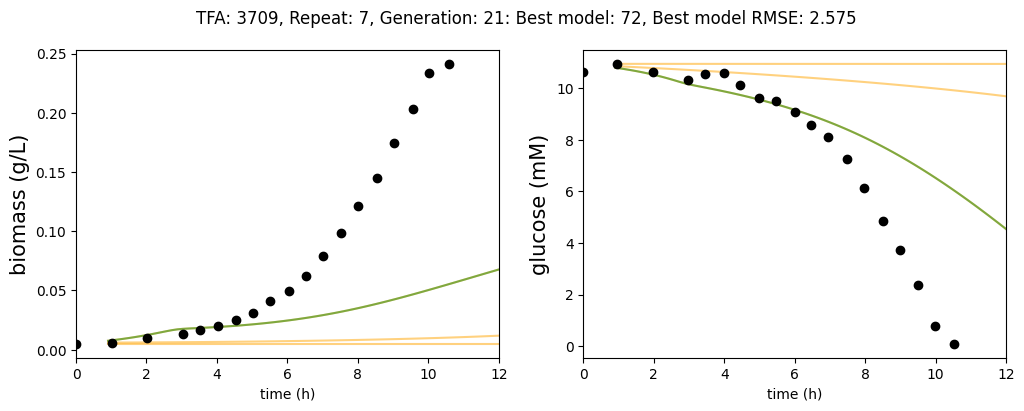

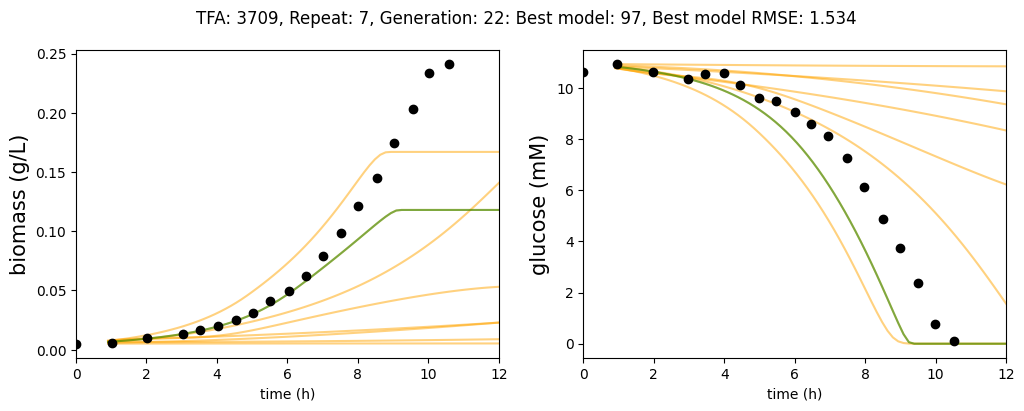

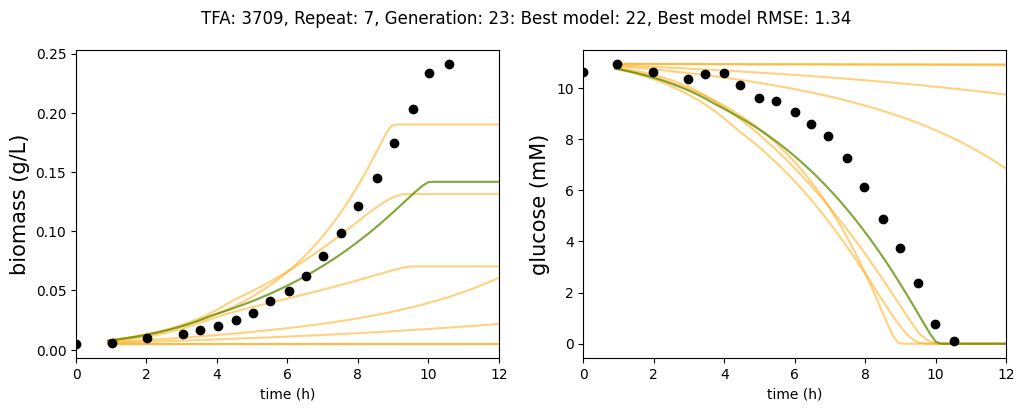

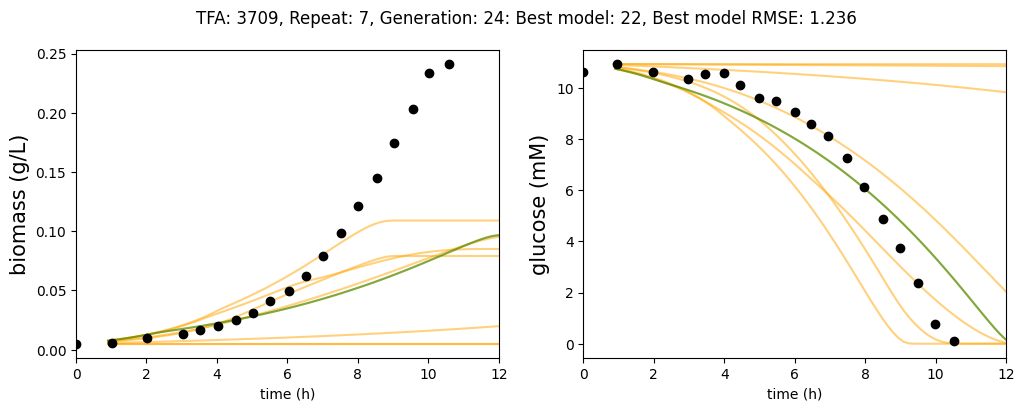

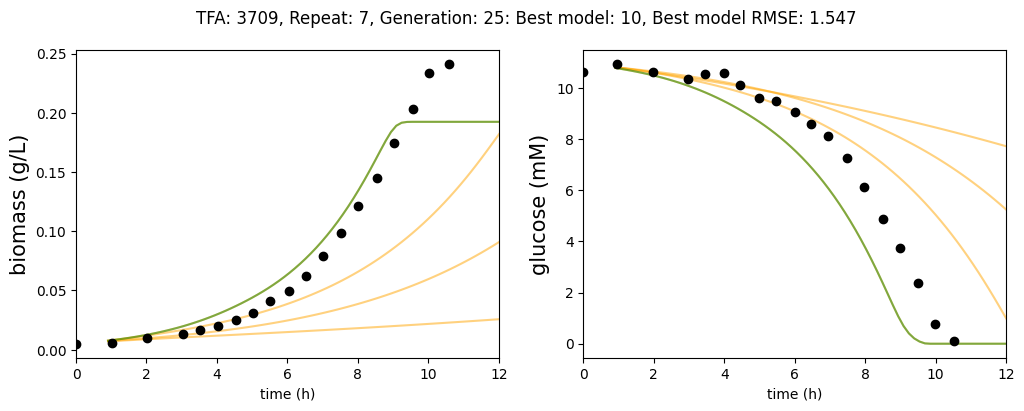

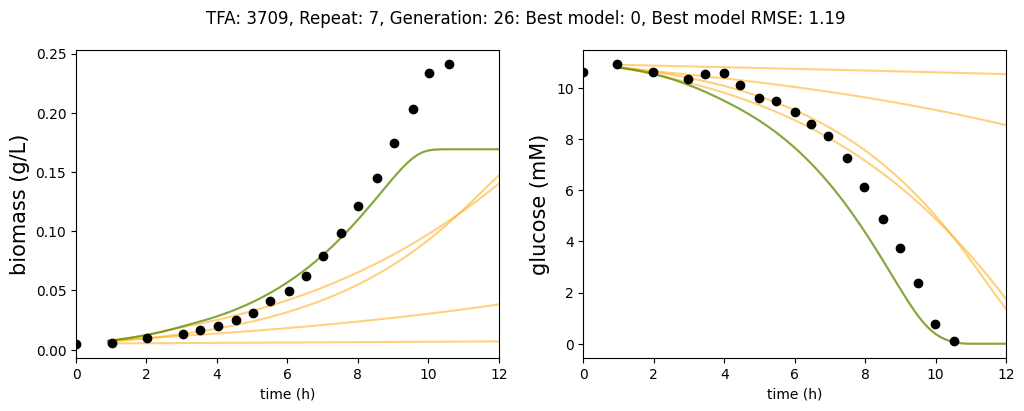

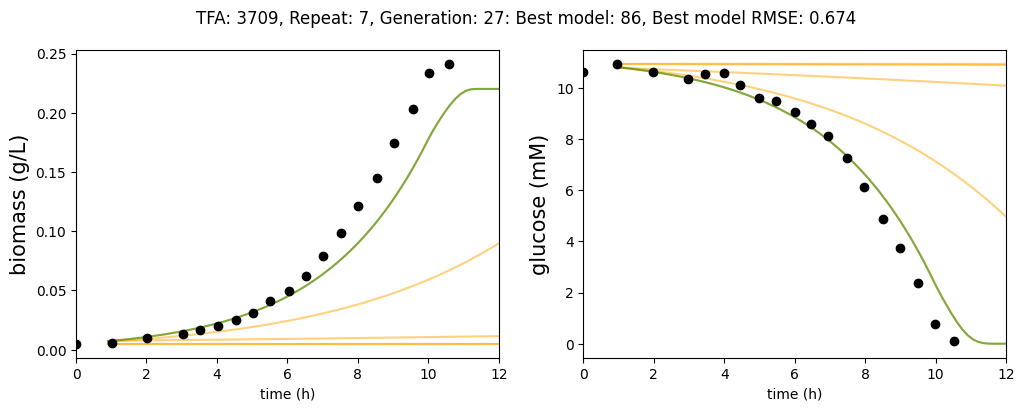

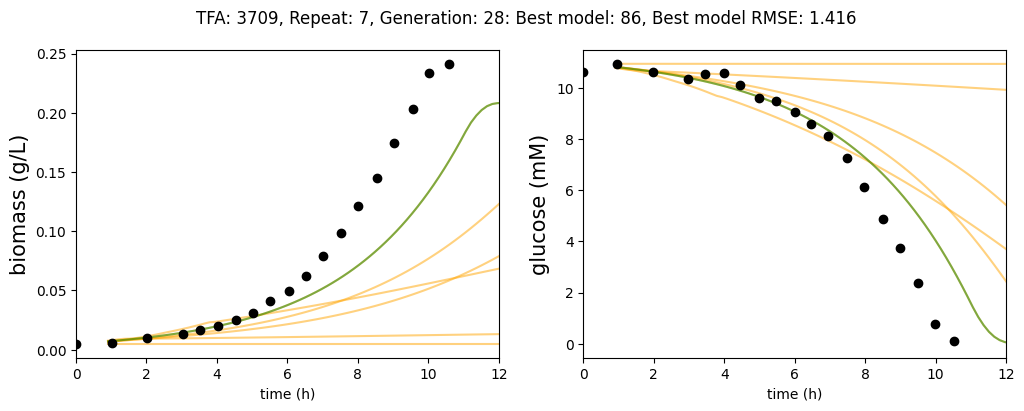

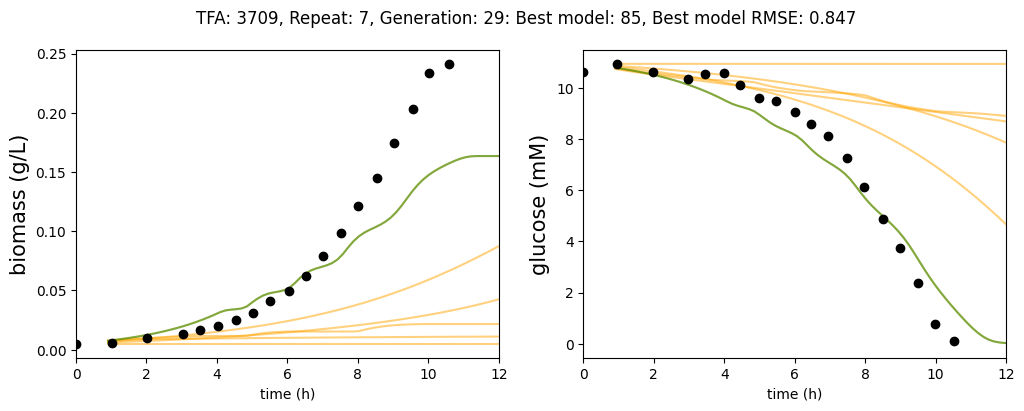

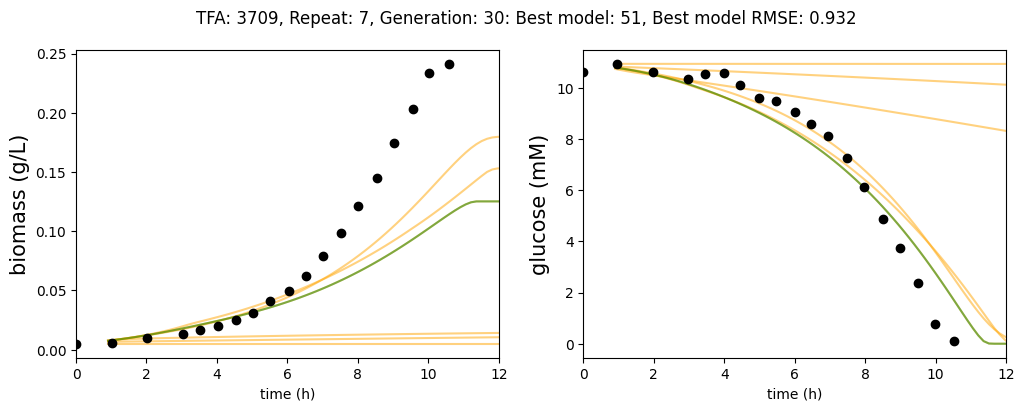

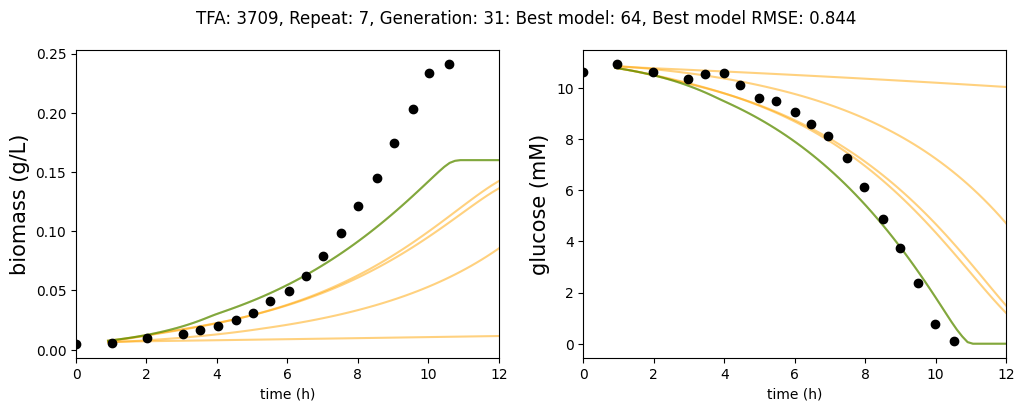

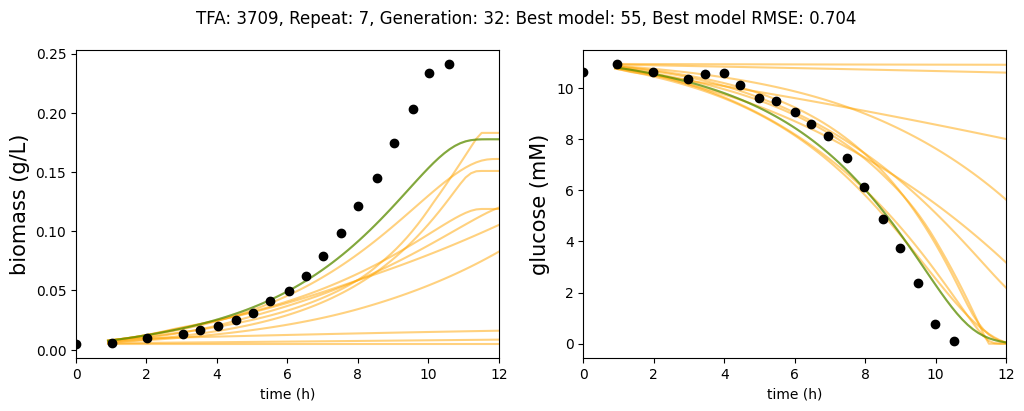

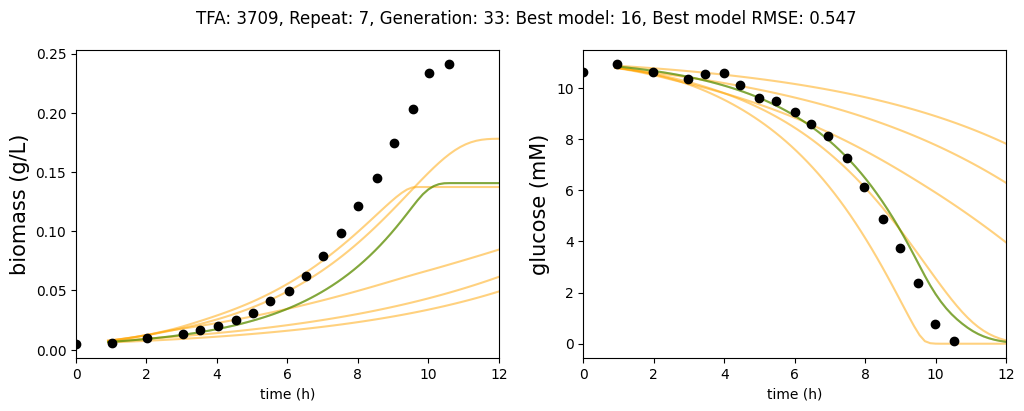

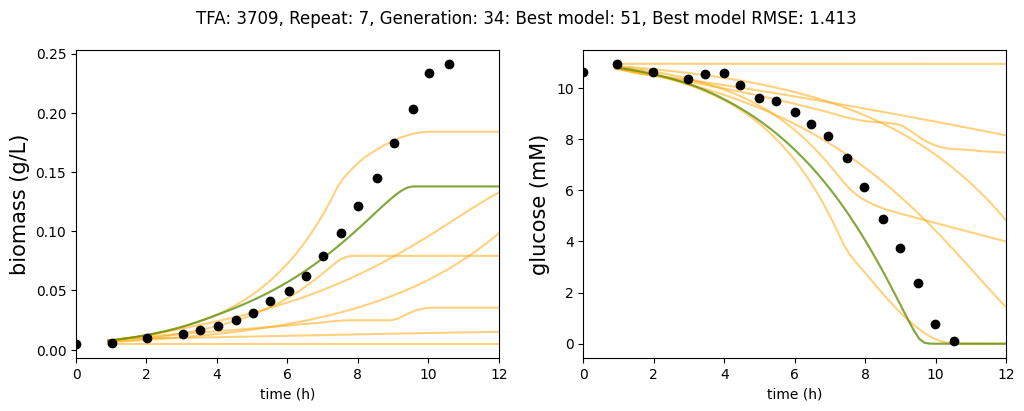

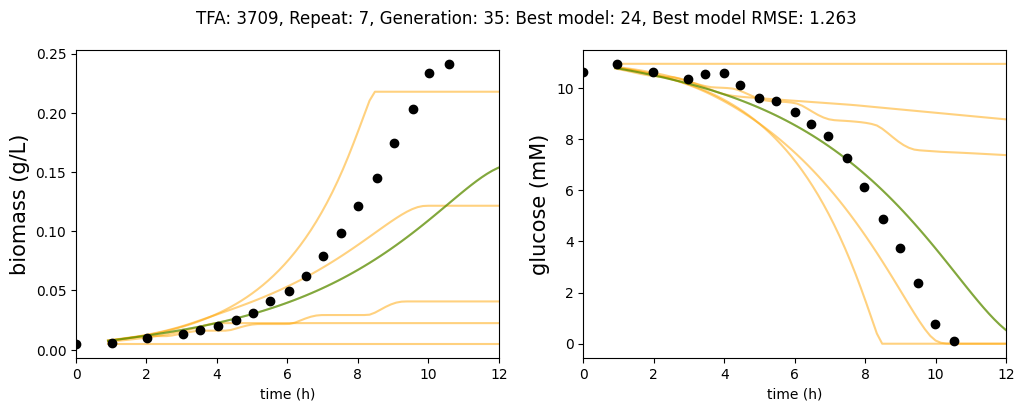

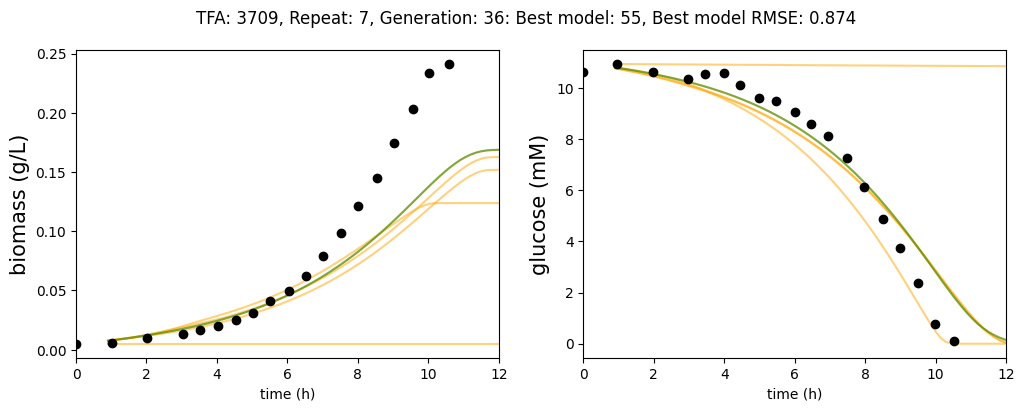

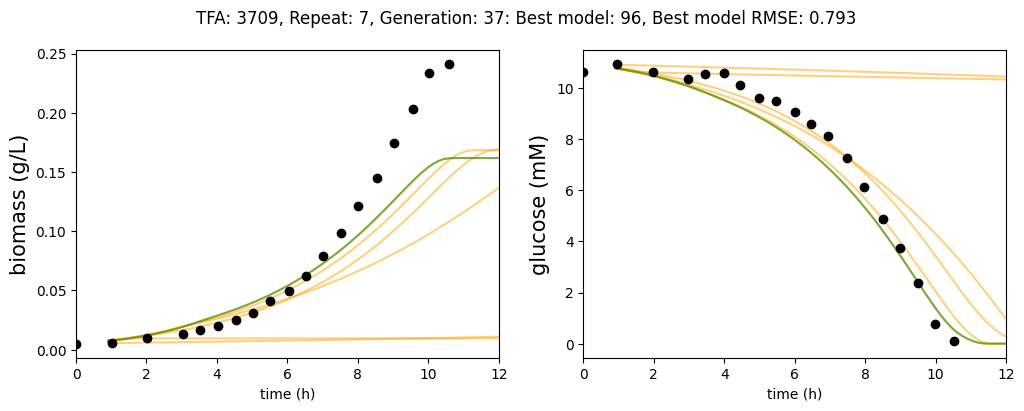

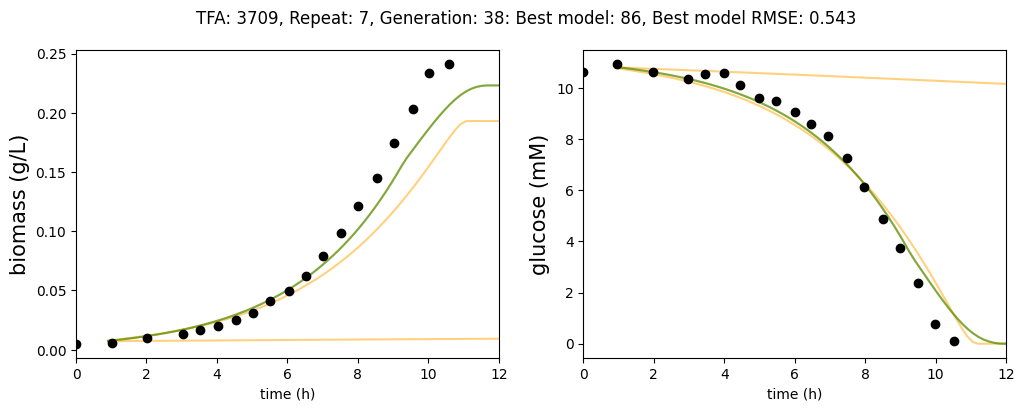

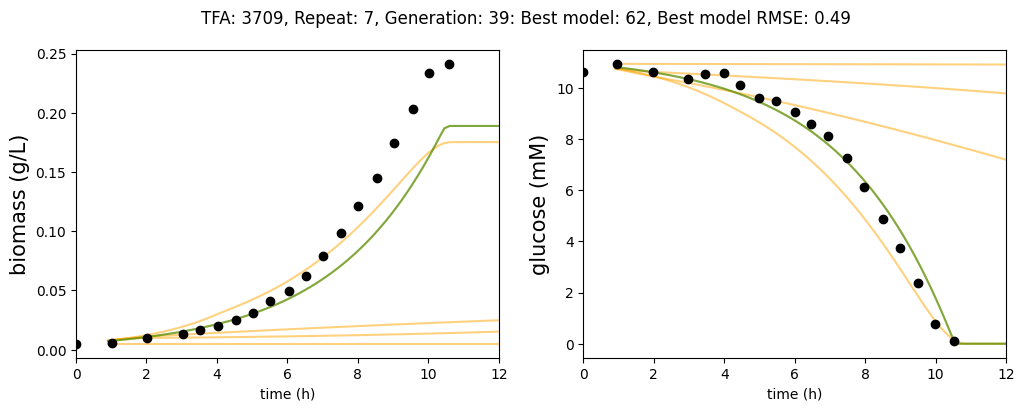

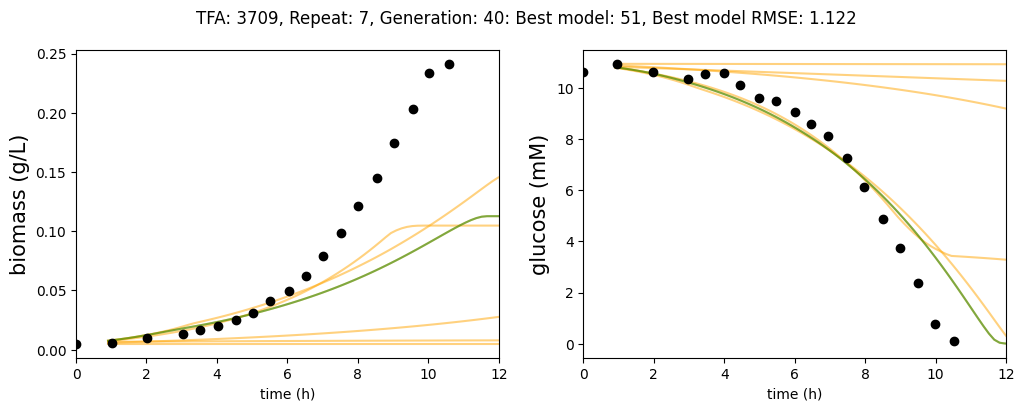

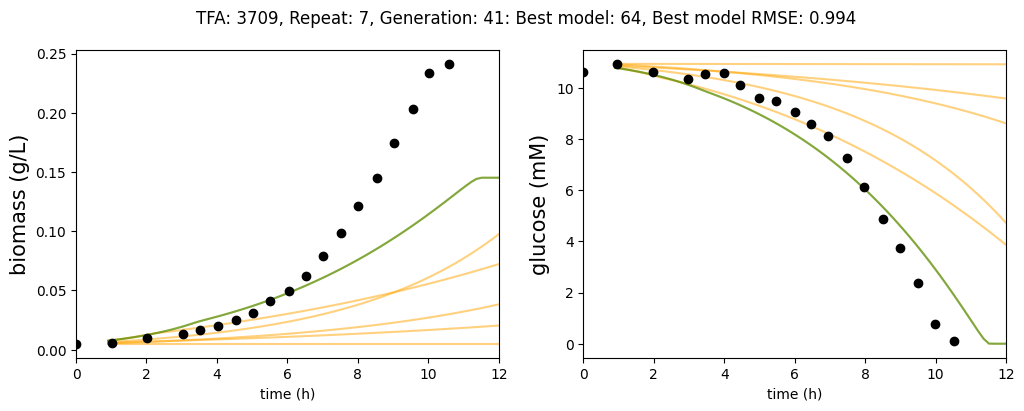

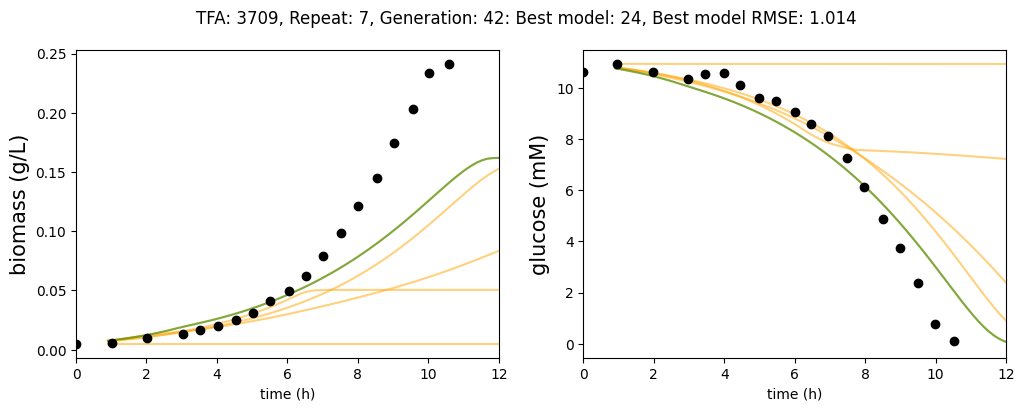

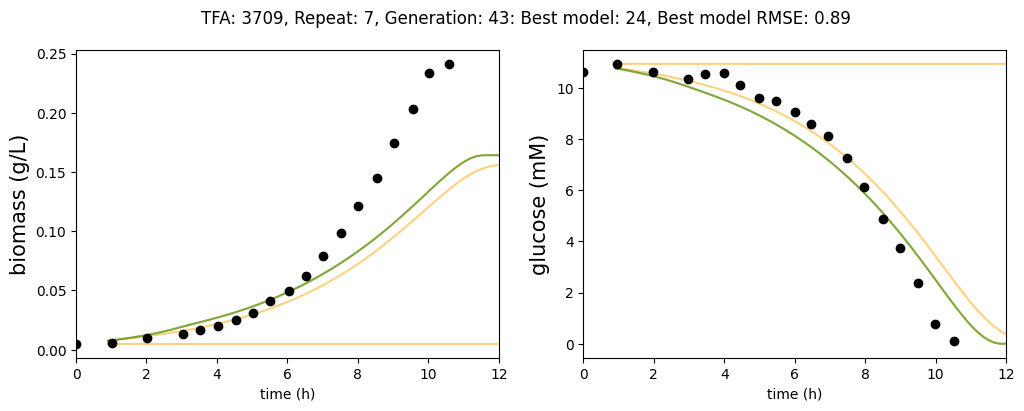

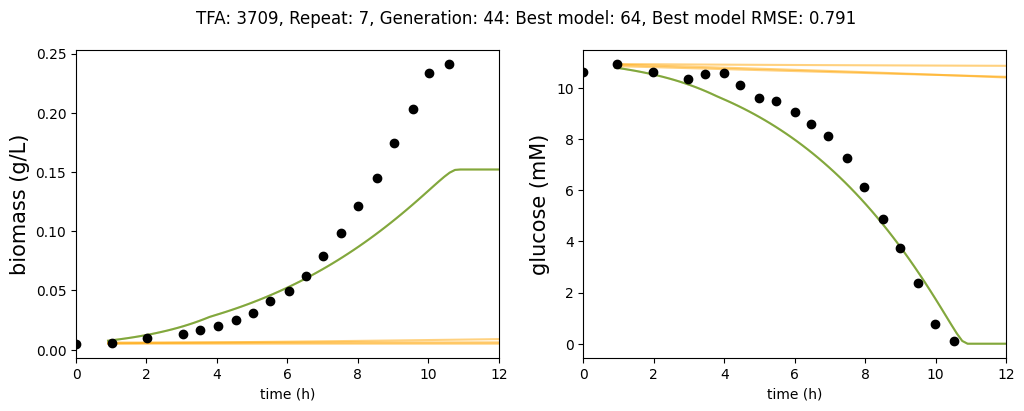

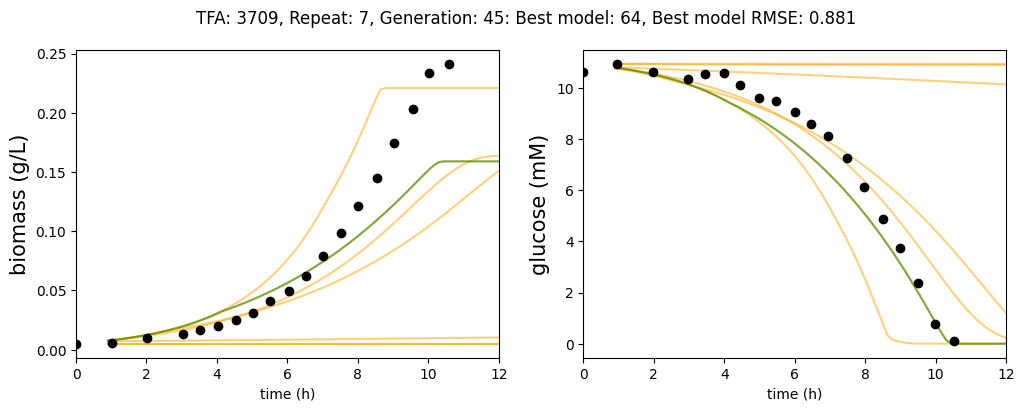

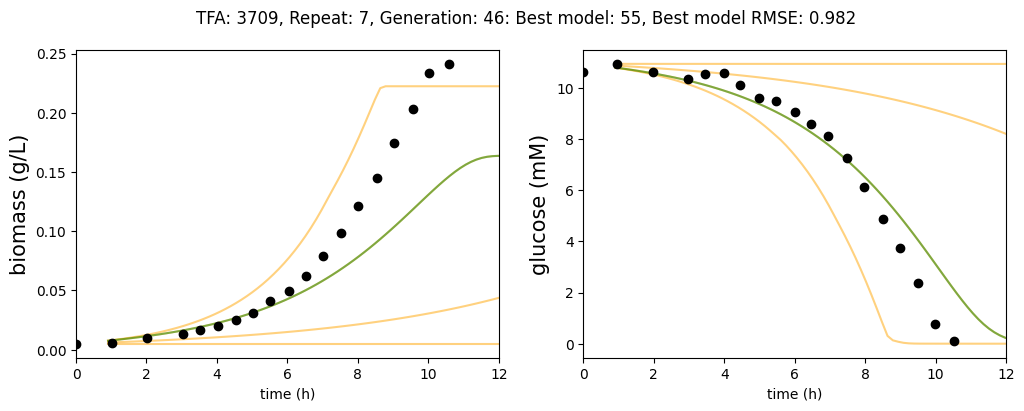

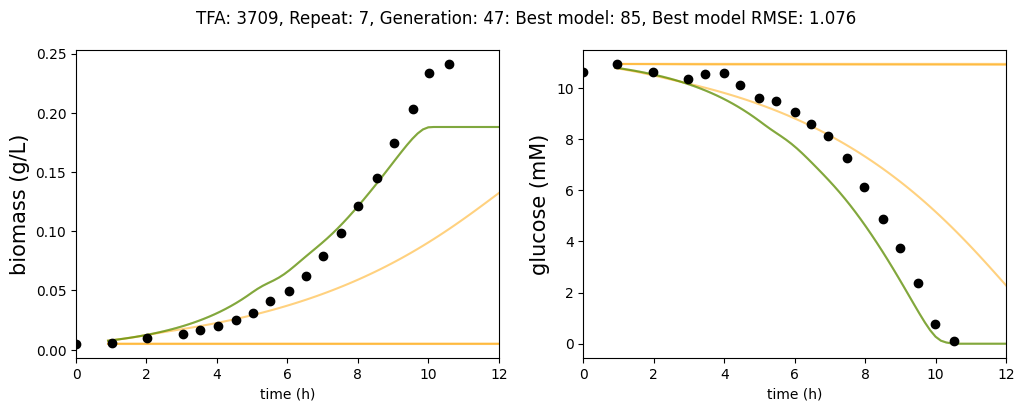

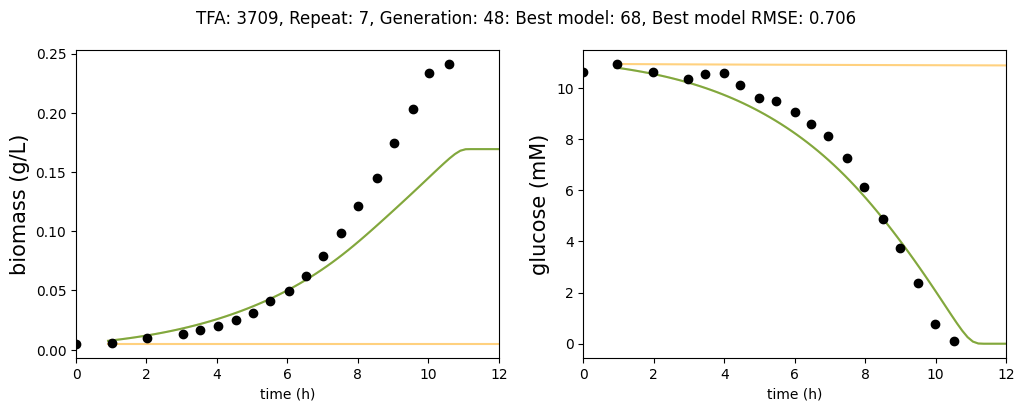

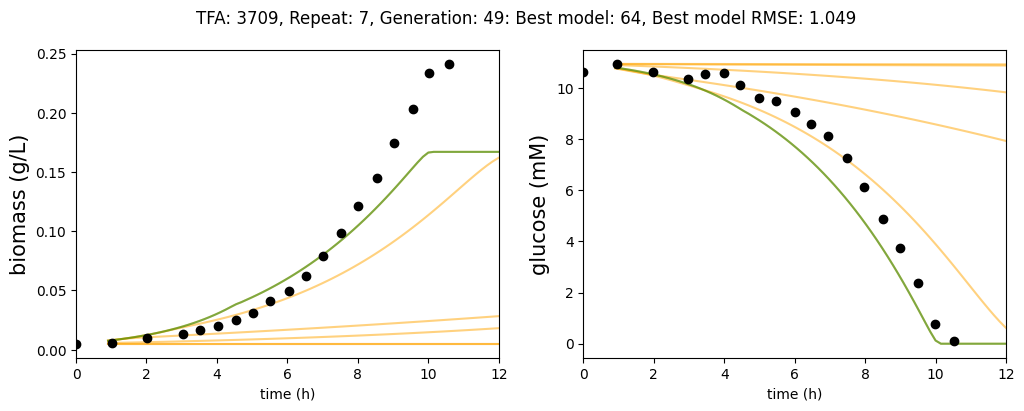

In [54]:
plot_path = f'figures/bioreactor_curves/'
os.makedirs(plot_path, exist_ok = True)

ss_ixs = [3709] #, 1593, 4327]
repeats = 2
generations = 50


PLOT = True
for ss_idx in ss_ixs:
    
    for rep in [7]:
        
        for gen in range(generations):


            idx_to_plot = []
            #Load stuff 
            path_to_sol = f'simulations/{ss_idx}/{rep}/sample_{gen}.csv'
            all_sols= pd.read_csv(path_to_sol)
            all_sol_ids = np.unique(all_sols['solution_id'])
            for sol_id in all_sol_ids:
                this_sol = all_sols[all_sols['solution_id']==sol_id]
                if len(this_sol)==N_STEPS: idx_to_plot.append(sol_id)
            
            
            path_to_sample = f'samples/{ss_idx}/{rep}/sample_{gen}.npy'
            this_sample = np.load(path_to_sample)
            
            path_to_max_eigs = f'samples/{ss_idx}/{rep}/sample_{gen}_max_eigs.csv'
            this_max_eigs = pd.read_csv(path_to_max_eigs).iloc[:,1].values
            valid_idx = np.where(this_max_eigs<=-0.5)[0]
            
            path_to_noise = f'samples/{ss_idx}/{rep}/noise_{gen}.npy'
            this_noise = np.load(path_to_noise)
            
            ## Calculate
            if len(idx_to_plot)!=0:
                this_rmse = calc_rmse(all_sols, idx_to_plot)
                rmse_min_idx = int(this_rmse[this_rmse['total_rmse'] == this_rmse['total_rmse'].min()]['solution_id'].values[0]) #get minimun rmse
                rmse_min_valid_idx = valid_idx[rmse_min_idx]

            lowest_rmse = np.round(np.min(this_rmse['total_rmse']),3)
            ### Plot

            if PLOT:
                
                fig = plt.figure(figsize = (12,4)) 
                plot_ix = 1
                
                
                for conc, scaling in list(dict_scaling.items()):
    
                    #load experimental data
                    exp_ = exp_data[conc]
                    mean = exp_[exp_.columns[1]]
                    time_exp = exp_[exp_.columns[0]]
    
                    plt.subplot(1,2,plot_ix)
    
                    # Plot simulated data
                    for sol_id in idx_to_plot:
                        this_sol = all_sols[all_sols['solution_id']==sol_id]
                        if len(this_sol[conc])==N_STEPS:
                            plt.plot(T[T_start_ix:], this_sol[conc][T_start_ix:]*scaling, color = 'orange', alpha = 0.5)

                    # Plot best fit
                    if len(idx_to_plot)!=0:
                        this_sol = all_sols[all_sols['solution_id']==rmse_min_idx]
                        plt.plot(T[T_start_ix:], this_sol[conc][T_start_ix:]*scaling, color = 'green', alpha = 0.5)
                    # Plot experimental data
                    if len(exp_.columns) > 2:
                        lo = exp_[exp_.columns[2]]
                        hi = exp_[exp_.columns[3]]
                        plt.errorbar(time_exp, mean, yerr=np.asarray([mean - lo, hi - mean]),
                                     fmt='ko', label= f'{conc}', capsize=5)
                    else:
                        plt.plot(time_exp, mean, 'ko', label=f'{conc}')  
                        plt.xlabel('time (h)')
                        plt.ylabel(labels[conc], fontsize = 15)
                        plt.xlim([0, 12])
    
                    plot_ix+=1
    
                fig.suptitle(f'TFA: {ss_idx}, Repeat: {rep}, Generation: {gen}: Best model: {rmse_min_valid_idx}, Best model RMSE: {lowest_rmse}')
    
                plt.savefig(f'{plot_path}/sim_{ss_idx}_{rep}_{gen}.png',dpi = 300, transparent = False, bbox_inches = 'tight')
                plt.show()
                plt.close()


In [19]:
sample_1 = pd.read_csv(f'samples/sample_1000_23.csv')
sample_2 = pd.read_csv(f'samples/sample_100_23.csv')

## load og solution
ss_idx = 3709
repeat = 1
gen = 23
valid_idx_og = 82
og_sols = pd.read_csv(f'samples/{ss_idx}/{repeat}/sample_{gen}.csv')
og_eigs = pd.read_csv(f'samples/{ss_idx}/{repeat}/sample_{gen}_max_eigs.csv').iloc[:,1].values
reverse_valid_idx = np.where(np.where(og_eigs<=-0.9)[0] == valid_idx_og)[0][0]
og_sol = og_sols[og_sols['solution_id'] == reverse_valid_idx]

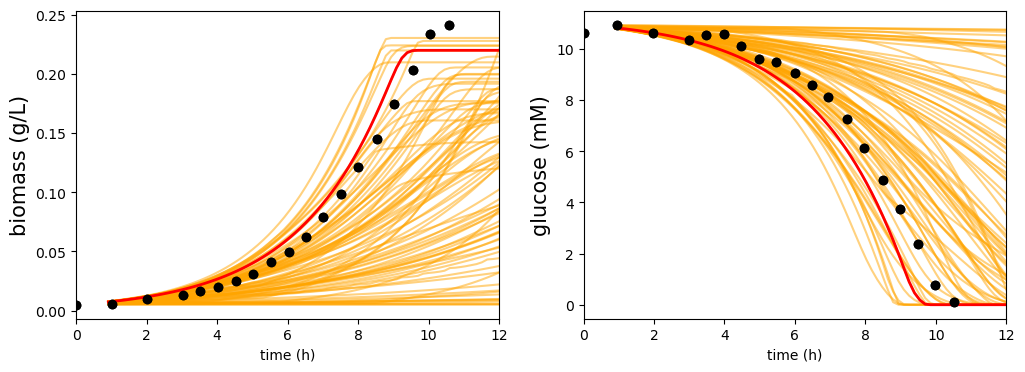

In [21]:
plot_path = f'figures/bioreactor_curves/'
os.makedirs(plot_path, exist_ok = True)

ss_ixs = 3709

idx_to_plot = []
#Load stuff 
path_to_sol = f'samples/sample_1000_23.csv'
all_sols= pd.read_csv(path_to_sol)
all_sol_ids = np.unique(all_sols['solution_id'])
for sol_id in all_sol_ids:
    this_sol = all_sols[all_sols['solution_id']==sol_id]
    if len(this_sol)==N_STEPS: idx_to_plot.append(sol_id)


path_to_sample = f'samples/sample_1000_23.npy'
this_sample = np.load(path_to_sample)

path_to_max_eigs = f'samples/sample_1000_23_max_eigs.csv'
this_max_eigs = pd.read_csv(path_to_max_eigs).iloc[:,1].values
valid_idx = np.where(this_max_eigs<=-0.5)[0]


lowest_rmse = np.round(np.min(this_rmse['total_rmse']),3)
### Plot

if PLOT:
    
    fig = plt.figure(figsize = (12,4)) 
    plot_ix = 1
    
    
    for conc, scaling in list(dict_scaling.items()):

        #load experimental data
        exp_ = exp_data[conc]
        mean = exp_[exp_.columns[1]]
        time_exp = exp_[exp_.columns[0]]

        plt.subplot(1,2,plot_ix)

        # Plot simulated data
        for sol_id in idx_to_plot:
            this_sol = all_sols[all_sols['solution_id']==sol_id]
            if len(this_sol[conc])==N_STEPS:
                plt.plot(T[T_start_ix:], this_sol[conc][T_start_ix:]*scaling, color = 'orange', alpha = 0.5)


        # Plot experimental data
        if len(exp_.columns) > 2:
            lo = exp_[exp_.columns[2]]
            hi = exp_[exp_.columns[3]]
            plt.errorbar(time_exp, mean, yerr=np.asarray([mean - lo, hi - mean]),
                         fmt='ko', label= f'{conc}', capsize=5)
        else:
            plt.plot(time_exp, mean, 'ko', label=f'{conc}')  
            plt.xlabel('time (h)')
            plt.ylabel(labels[conc], fontsize = 15)
            plt.xlim([0, 12])

        plot_ix+=1

    #fig.suptitle(f'TFA: {ss_idx}, Repeat: {rep}, Generation: {gen}: Best model: {rmse_min_valid_idx}, Best model RMSE: {lowest_rmse}')

#Load stuff 
idx_to_plot = []
path_to_sol = f'samples/sample_100_23.csv'
all_sols= pd.read_csv(path_to_sol)
all_sol_ids = np.unique(all_sols['solution_id'])
for sol_id in all_sol_ids:
    this_sol = all_sols[all_sols['solution_id']==sol_id]
    if len(this_sol)==N_STEPS: idx_to_plot.append(sol_id)


path_to_sample = f'samples/sample_100_23.npy'
this_sample = np.load(path_to_sample)

path_to_max_eigs = f'samples/sample_100_23_max_eigs.csv'
this_max_eigs = pd.read_csv(path_to_max_eigs).iloc[:,1].values
valid_idx = np.where(this_max_eigs<=-0.5)[0]

### Plot

if PLOT: 
    plot_ix = 1
    
    
    for conc, scaling in list(dict_scaling.items()):

        #load experimental data
        exp_ = exp_data[conc]
        mean = exp_[exp_.columns[1]]
        time_exp = exp_[exp_.columns[0]]

        plt.subplot(1,2,plot_ix)

        # Plot simulated data
        for sol_id in idx_to_plot:
            this_sol = all_sols[all_sols['solution_id']==sol_id]
            if len(this_sol[conc])==N_STEPS:
                plt.plot(T[T_start_ix:], this_sol[conc][T_start_ix:]*scaling, color = 'orange', alpha = 0.5)

        # Plot original
        plt.plot(T[T_start_ix:], og_sol[conc][T_start_ix:]*scaling, lw = 2, color = 'red', label = 'original')
        # Plot experimental data
        if len(exp_.columns) > 2:
            lo = exp_[exp_.columns[2]]
            hi = exp_[exp_.columns[3]]
            plt.errorbar(time_exp, mean, yerr=np.asarray([mean - lo, hi - mean]),
                         fmt='ko', label= f'{conc}', capsize=5)
        else:
            plt.plot(time_exp, mean, 'ko', label=f'{conc}')  
            plt.xlabel('time (h)')
            plt.ylabel(labels[conc], fontsize = 15)
            plt.xlim([0, 12])

        plot_ix+=1


    plt.savefig(f'sample_1000.svg',dpi = 300, transparent = False, bbox_inches = 'tight')
    plt.show()
    plt.close()


In [16]:
idx_to_plot

[2, 4, 5, 6, 7, 14, 15, 16, 17, 21, 23, 26]